In [110]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 
import ast
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [111]:
# Converts literal to lists
def safe_eval(value):
    try:
        return ast.literal_eval(value) if isinstance(value, str) and value.startswith("[") else [value]
    except (SyntaxError, ValueError):
        return [value]

In [112]:
def train_cv(model, X, y, metric = 'rmse', kfold = 5):

    if metric != 'rmse':
        raise NotImplemented

    scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')

    mse_scores = -scores
    rmse_scores = np.sqrt(mse_scores)

    return rmse_scores.mean(), rmse_scores.std()

In [113]:
df_train = pd.read_csv('../data/raw/actuarial-loss-estimation/train.csv', index_col=0)
df_nlp_descriptors_train = pd.read_csv('../data/processed/df_train_nlp_completions.csv', index_col=0)

df_embeddings_events = pd.read_csv('../data/processed/embeddings_events.csv', index_col=0)
df_embeddings_body_parts = pd.read_csv('../data/processed/embeddings_body_parts.csv', index_col=0)

In [114]:
df_train = df_train[df_train.UltimateIncurredClaimCost < 4e6]

In [115]:
df_train_texts = df_nlp_descriptors_train.join(df_train[['UltimateIncurredClaimCost']], how='right')
df_train_texts

,event,affected_body_part,UltimateIncurredClaimCost
ClaimNumber,,,
WC8285054,INJURY LIFTING TYRE,"['RIGHT ARM', 'RIGHT WRIST']",4748.203388
WC6982224,STEPPED AROUND CRATES AND TRUCK TRAY,['FOREARM'],6326.285819
WC5481426,CUT ON SHARP EDGE,['LEFT THUMB'],2293.949087
WC9775968,DIGGING LOWER BACK,['LOWER BACK'],17786.487170
WC2634037,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STRAIN,['LEFT STOMACH'],4014.002925
...,...,...,...
WC9370727,STRUCK KNIFE LACERATED,['LEFT MIDDLE FINGER'],480.493308
WC8396269,LACERATION LEFT HAND,"['BACK', 'LEFT LEG']",755.735319
WC3609528,METAL SLIPPED ACROSS METAL CUT,['FINGER'],418.178461


In [116]:
df_train_texts["affected_body_part"] = df_train_texts["affected_body_part"].apply(safe_eval)

## Exploration of EVENT

In [8]:
df_train_texts.event.value_counts()[df_train_texts.event.value_counts() > 100]

event
MOTOR VEHICLE ACCIDENT                   506
FELL DOWN STAIRS                         366
INJURY                                   349
SLIPPED ON WET FLOOR                     342
LACERATION                               292
SLIPPED ON ROLLER                        256
BACK STRAIN                              246
STRAIN                                   243
SLIPPED USING LATHE                      242
STRUCK KNIFE LACERATION                  226
FELL OFF LADDER                          223
SORTING ALUMINIUM BARS STRAIN            194
SLIPPED ON STAIRS                        194
STRUCK KNIFE LACERATED                   194
CLEANING INSTRUMENTS                     194
HIT AIR HOSE                             180
HIT FLOOR SHEET                          177
KNIFE LACERATION                         176
GRINDING STEEL BEAM INFECTION            168
KNIFE SLIPPED                            164
LIFTING                                  155
FELL FROM LADDER                         155
REDB

In [9]:
# top 250 events and body_parts
top_events = df_train_texts.event.value_counts().head(250).index.values

In [10]:
df_train_texts[df_train_texts.event.isin(top_events)]

,event,affected_body_part,UltimateIncurredClaimCost
ClaimNumber,,,
WC9775968,DIGGING LOWER BACK,[LOWER BACK],17786.487170
WC7539849,CLEANING LEFT SHOULDER SPLINTER,[LEFT HAND],1877.172243
WC6193926,TO RIGHT LEG,[RIGHT KNEE],1343.513498
WC8342953,FALL FROM LADDER,[SHOULDER],105285.148600
WC4302308,CUTTING MATERIAL,[FINGER],2054.868515
...,...,...,...
WC7430033,CUTTING WITH KNIFE,"[LEFT THUMB, LEFT INDEX FINGER]",495.718394
WC3063028,MOTOR VEHICLE ACCIDENT,[NECK],12008.194150
WC3485403,INJURY LIFTING DOOR,"[SHOULDER, LEFT FOREARM, LEFT HIP]",2633.844395


In [117]:
event_medians = df_train_texts[
    df_train_texts.event.isin(top_events)
    ].groupby('event')['UltimateIncurredClaimCost'].median().sort_values(ascending=False)

In [118]:
event_medians

event
WORKPLACE STRESS              44122.356910
LIFTING GATE STRAIN           33371.081160
TRIPPED FELL STRAIN           21706.179650
LOWER BACK PAIN               16122.249480
REPETITIVE WORK STRAIN        14179.448390
                                  ...     
GRINDING METAL                  340.753843
FOREIGN BODY                    316.006423
FOREIGN BODY ENTERED EYE        313.470076
INJURY EYE                      312.741611
FOREIGN BODY FLEW INTO EYE      308.784094
Name: UltimateIncurredClaimCost, Length: 250, dtype: float64

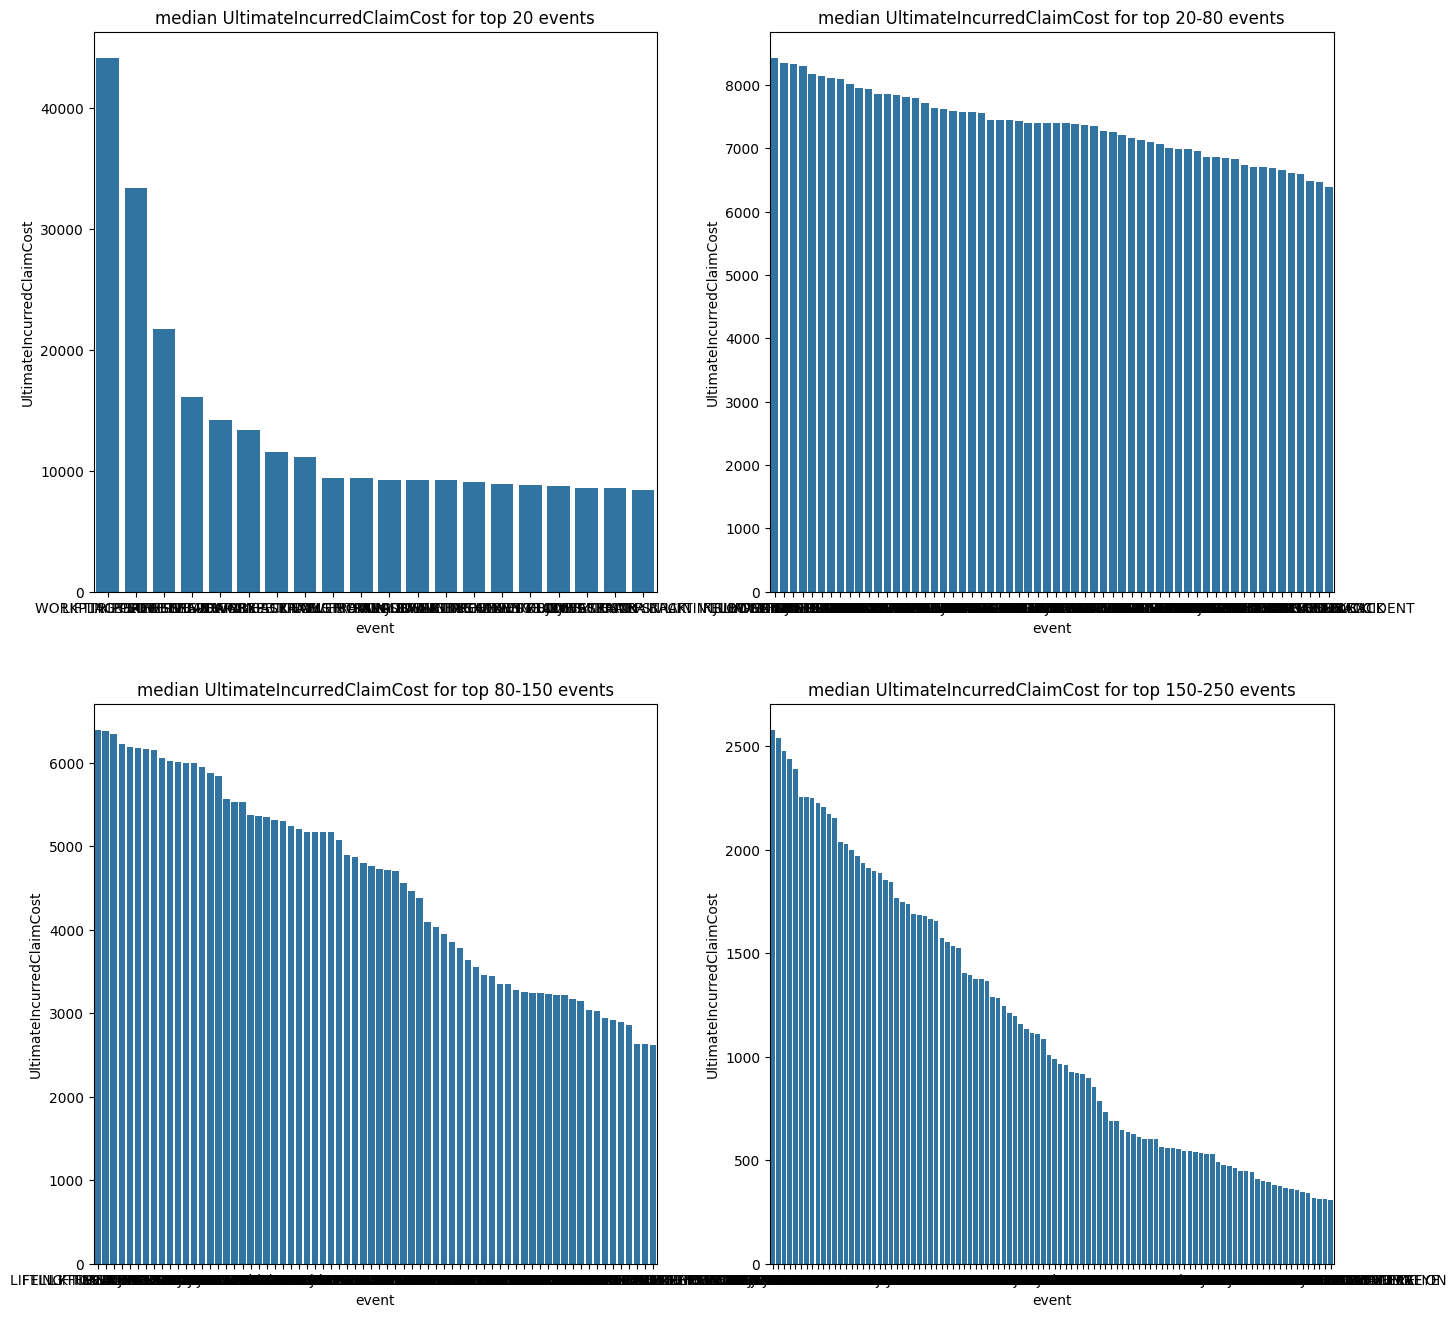

In [119]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

sns.barplot(event_medians[:20], ax=ax[0, 0])
ax[0, 0].set_title('median UltimateIncurredClaimCost for top 20 events')

sns.barplot(event_medians[20:80], ax=ax[0, 1])
ax[0, 1].set_title('median UltimateIncurredClaimCost for top 20-80 events')

sns.barplot(event_medians[80:150], ax=ax[1, 0])
ax[1, 0].set_title('median UltimateIncurredClaimCost for top 80-150 events')

sns.barplot(event_medians[150:], ax=ax[1, 1])
ax[1, 1].set_title('median UltimateIncurredClaimCost for top 150-250 events')

plt.show()

### Train only on event embeddings 

In [14]:
df_train_with_embeddings = df_train_texts.join(df_embeddings_events, on='event')
print(df_train_with_embeddings.shape)
df_train_with_embeddings.head()

(53999, 771)


,event,affected_body_part,UltimateIncurredClaimCost,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,...,feat_758,feat_759,feat_760,feat_761,feat_762,feat_763,feat_764,feat_765,feat_766,feat_767
ClaimNumber,,,,,,,,,,,,,,,,,,,,,
WC8285054,INJURY LIFTING TYRE,"[RIGHT ARM, RIGHT WRIST]",4748.203388,0.010224,-0.008979,-0.153203,-0.046708,0.016435,0.014400,0.007274,...,0.094073,-0.044662,0.006170,-0.027248,-0.008825,-0.040654,0.002053,0.017474,-0.038694,0.032358
WC6982224,STEPPED AROUND CRATES AND TRUCK TRAY,[FOREARM],6326.285819,-0.035648,0.045628,-0.162840,-0.018556,0.003661,0.016655,0.031907,...,0.102261,0.000294,0.034455,0.026042,-0.023603,0.014823,-0.025118,-0.016251,-0.054481,0.018184
WC5481426,CUT ON SHARP EDGE,[LEFT THUMB],2293.949087,0.059115,0.011514,-0.153140,0.027770,0.024657,-0.010284,-0.007715,...,0.083443,0.011950,0.025244,-0.025845,0.032487,0.010088,-0.000443,-0.037085,-0.042041,-0.019674
WC9775968,DIGGING LOWER BACK,[LOWER BACK],17786.487170,0.088880,0.051487,-0.143221,-0.040761,0.017948,0.027475,0.045827,...,0.083236,-0.004408,0.005443,-0.038952,0.047937,0.019580,0.001715,-0.018154,-0.052198,0.044447
WC2634037,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STRAIN,[LEFT STOMACH],4014.002925,0.035530,0.029204,-0.203067,0.002893,-0.015865,-0.002419,0.022961,...,0.074492,-0.009232,-0.021835,-0.043457,0.069049,-0.018228,-0.005461,0.006898,-0.047432,-0.014228


In [15]:
cols_embeddings = [col for col in df_train_with_embeddings.columns if col[:4] == 'feat']

In [16]:
X = df_train_with_embeddings[cols_embeddings]
y = df_train_with_embeddings['UltimateIncurredClaimCost']

In [17]:
rmse_mean, rmse_std = train_cv(Lasso(), X, y)

print(f'Cross validated RMSE: {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE: 28012.25 ± 1197.66


In [18]:
rmse_mean, rmse_std = train_cv(XGBRegressor(n_estimators=100), X, y)

print(f'Cross validated RMSE: {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE: 29650.17 ± 1354.28


RMSE for the linear model is lower than then __initial modelling__, while XGB is slightly larger. Initial modelling considered only the numerical and categorical variables.

Same experiment but with dimensionality reduction.

In [19]:
pipeline = Pipeline([
    ('pca', PCA(n_components=50)),
    ('regressor', Lasso())
])

rmse_mean, rmse_std = train_cv(pipeline, X, y)
print(f'Cross validated RMSE: {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE: 28032.78 ± 1196.90


In [20]:
pipeline = Pipeline([
    ('pca', PCA(n_components=50)),
    ('regressor', XGBRegressor(n_estimators=100))
])

rmse_mean, rmse_std = train_cv(pipeline, X, y)

print(f'Cross validated RMSE: {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE: 29293.37 ± 1328.02


PCA doesn't seem to make a big impact on RMSE, but makes for a faster convergence.

### Train on event descriptions instead
Using all descriptions (even the less popular ones)

In [21]:
X = pd.get_dummies(df_train_texts['event'])
y = df_train_texts['UltimateIncurredClaimCost']

In [22]:
rmse_mean, rmse_std = train_cv(Lasso(), X, y)

print(f'Cross validated RMSE (linear regression): {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE (linear regression): 29453.52 ± 1462.15


In [23]:
# fix for xgboost
X.columns = [f'c_{i}' for i in range(len(X.columns))]
rmse_mean, rmse_std = train_cv(XGBRegressor(n_estimators=100), X, y)

print(f'Cross validated RMSE (xgboost): {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE (xgboost): 28918.82 ± 1308.77


The simple one-hot encoding actually has a performance comparable to the embeddings. Now let's try with dimensionality reduction.

In [24]:
pipeline = Pipeline([
    ('pca', PCA(n_components=50)),
    ('regressor', Lasso())
])

rmse_mean, rmse_std = train_cv(pipeline, X, y)
print(f'Cross validated RMSE: {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE: 28483.90 ± 1192.12


In [25]:
pipeline = Pipeline([
    ('pca', PCA(n_components=50)),
    ('regressor', XGBRegressor(n_estimators=100))
])

rmse_mean, rmse_std = train_cv(pipeline, X, y)

print(f'Cross validated RMSE: {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE: 31254.30 ± 3415.81


In this case PCA did improve the linear model, XGBoost struggled with it. 

Predicting only for the most popular items? 

In [26]:
# filtering for those with events in high frequency
X = pd.get_dummies(df_train_texts.loc[df_train_texts.event.isin(top_events), 'event'])
y = df_train_texts.loc[df_train_texts.event.isin(top_events), 'UltimateIncurredClaimCost'] 

In [27]:
rmse_mean, rmse_std = train_cv(Lasso(), X, y)

print(f'Cross validated RMSE for linear regression: {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE for linear regression: 27125.11 ± 1785.09


In [28]:
# fix for xgboost
X.columns = [f'c_{i}' for i in range(len(X.columns))]
rmse_mean, rmse_std = train_cv(XGBRegressor(n_estimators=100), X, y)

print(f'Cross validated RMSE (xgboost): {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE (xgboost): 27110.71 ± 1793.21


For the subset of accidents with the most frequency, the results are even better. Will it perform even better as I continue to reduce the number of top elements?

In [29]:
for n in (5, 10, 30, 50, 100, 120, 150)[::-1]:
    print(f'Testing for top {n} events')
    X = pd.get_dummies(df_train_texts.loc[df_train_texts.event.isin(top_events[:n]), 'event'])
    y = df_train_texts.loc[df_train_texts.event.isin(top_events[:n]), 'UltimateIncurredClaimCost'] 

    rmse_mean, rmse_std = train_cv(Lasso(), X, y)

    print(f'Cross validated RMSE for linear regression: {rmse_mean:.2f} ± {rmse_std:.2f}')

    # fix for xgboost
    X.columns = [f'c_{i}' for i in range(len(X.columns))]
    rmse_mean, rmse_std = train_cv(XGBRegressor(n_estimators=100), X, y)

    print(f'Cross validated RMSE (xgboost): {rmse_mean:.2f} ± {rmse_std:.2f}')


Testing for top 150 events
Cross validated RMSE for linear regression: 27115.23 ± 1841.91
Cross validated RMSE (xgboost): 27107.46 ± 1858.76
Testing for top 120 events
Cross validated RMSE for linear regression: 26275.57 ± 1695.59
Cross validated RMSE (xgboost): 26272.13 ± 1703.05
Testing for top 100 events
Cross validated RMSE for linear regression: 26621.74 ± 2115.70
Cross validated RMSE (xgboost): 26619.06 ± 2121.33
Testing for top 50 events
Cross validated RMSE for linear regression: 26141.81 ± 2679.78
Cross validated RMSE (xgboost): 26142.12 ± 2679.46
Testing for top 30 events
Cross validated RMSE for linear regression: 26651.93 ± 3570.34
Cross validated RMSE (xgboost): 26652.77 ± 3569.28
Testing for top 10 events
Cross validated RMSE for linear regression: 28298.57 ± 5801.42
Cross validated RMSE (xgboost): 28298.61 ± 5801.14
Testing for top 5 events
Cross validated RMSE for linear regression: 29795.02 ± 3125.97
Cross validated RMSE (xgboost): 29795.03 ± 3125.84


Interestingly enough the best error is achieved when predicting for the top 50 and top 120 events and the most popular seem to increase it. This lead me to believe that there is more variability among the top ~5-10.

In [30]:
n = 50
n_to_exclude = 5

print(f'Testing for top {n} events, excluding the top {n_to_exclude}')
X = pd.get_dummies(df_train_texts.loc[df_train_texts.event.isin(top_events[n_to_exclude:n]), 'event'])
y = df_train_texts.loc[df_train_texts.event.isin(top_events[n_to_exclude:n]), 'UltimateIncurredClaimCost'] 

rmse_mean, rmse_std = train_cv(Lasso(), X, y)

print(f'Cross validated RMSE for linear regression: {rmse_mean:.2f} ± {rmse_std:.2f}')

# fix for xgboost
X.columns = [f'c_{i}' for i in range(len(X.columns))]
rmse_mean, rmse_std = train_cv(XGBRegressor(n_estimators=100), X, y)

print(f'Cross validated RMSE (xgboost): {rmse_mean:.2f} ± {rmse_std:.2f}')


Testing for top 50 events, excluding the top 5
Cross validated RMSE for linear regression: 24939.11 ± 3062.52
Cross validated RMSE (xgboost): 24939.58 ± 3062.26


In [31]:
n = 50
n_to_exclude = 2

print(f'Testing for top {n} events, excluding the top {n_to_exclude}')
X = pd.get_dummies(df_train_texts.loc[df_train_texts.event.isin(top_events[n_to_exclude:n]), 'event'])
y = df_train_texts.loc[df_train_texts.event.isin(top_events[n_to_exclude:n]), 'UltimateIncurredClaimCost'] 

rmse_mean, rmse_std = train_cv(Lasso(), X, y)

print(f'Cross validated RMSE for linear regression: {rmse_mean:.2f} ± {rmse_std:.2f}')

# fix for xgboost
X.columns = [f'c_{i}' for i in range(len(X.columns))]
rmse_mean, rmse_std = train_cv(XGBRegressor(n_estimators=100), X, y)

print(f'Cross validated RMSE (xgboost): {rmse_mean:.2f} ± {rmse_std:.2f}')


Testing for top 50 events, excluding the top 2
Cross validated RMSE for linear regression: 24477.23 ± 2868.47
Cross validated RMSE (xgboost): 24477.64 ± 2868.16


I would expect an impact on adding the top 50 categories directly. 

### Can a prediction be made only on the median cost by event? 

__Important:__ Including the current row will result in data contamination (specially for low-frequency values)

In [ ]:
from sklearn.model_selection import KFold

# 

def safe_event_median_cost(nlp_descriptors_train: pd.Series, ultimate_cost: pd.Series):
    """
    nlp_descriptors_train: pandas Series with the claim number as index and event (str) as values
    ultimate_cost: a pandas Series containing all the feature values 
    """

    kf = KFold(n_splits=20, shuffle=True, random_state=42)

    df = nlp_descriptors_train.rename('event').to_frame().join(ultimate_cost.rename('claim_cost'))

    for reference_idx, fill_idx in kf.split(df):
        fold_reference, fold_to_fill = df.iloc[reference_idx], df.iloc[fill_idx]        
        
        # Compute category median using only the training folds
        fold_medians_event = fold_reference.groupby('event')['claim_cost'].median()
        fold_median_general = fold_reference['claim_cost'].median()
        

        # Apply to validation fold
        df.loc[fold_to_fill.index, 'event_median'] = df.loc[fold_to_fill.index, 'event'].map(fold_medians_event)
        df.loc[fold_to_fill.index, 'event_median'] = df.loc[fold_to_fill.index, 'event_median'].fillna(fold_median_general)

    return df

In [141]:
df_medians = safe_event_median_cost(df_nlp_descriptors_train['event'], df_train['UltimateIncurredClaimCost']).dropna()

In [142]:
X = df_medians[['event_median']]
y = df_medians['claim_cost']

In [143]:
rmse_mean, rmse_std = train_cv(LinearRegression(), X, y)

print(f'Cross validated RMSE for linear regression: {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE for linear regression: 28478.64 ± 1087.87


In [144]:

rmse_mean, rmse_std = train_cv(XGBRegressor(n_estimators=100), X, y)

print(f'Cross validated RMSE (xgboost): {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE (xgboost): 28192.30 ± 1095.36


The historical median by event yields a decent prediction

### Body parts

I will now focus on the affected body parts

In [36]:
# since affected_body_parts is a lists column, I will explode it, join with the embeddings
# and then perform mean pooling to obtain one embedding per row 

df_train_with_embeddings = df_train_texts.affected_body_part.explode().to_frame(
    ).join(df_embeddings_body_parts, on='affected_body_part').drop(columns='affected_body_part'
    ).reset_index().groupby(['ClaimNumber']).mean()

# add the target
df_train_with_embeddings['UltimateIncurredClaimCost'] = df_train['UltimateIncurredClaimCost'].reindex(df_train_with_embeddings.index)

print(df_train_with_embeddings.shape)
df_train_with_embeddings.head()

(53999, 769)


,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_759,feat_760,feat_761,feat_762,feat_763,feat_764,feat_765,feat_766,feat_767,UltimateIncurredClaimCost
ClaimNumber,,,,,,,,,,,,,,,,,,,,,
WC1592889,0.013260,0.035785,-0.115971,0.008269,0.008015,0.033906,0.043501,0.001778,0.088991,-0.000026,...,0.014877,0.042244,-0.030100,0.055743,-0.011972,0.048911,-0.029553,-0.043349,0.019504,740.112571
WC1592905,0.047664,0.007552,-0.129151,-0.005918,0.003217,0.014605,0.049369,0.040746,-0.006884,0.003309,...,0.010997,0.016218,-0.044370,0.029592,-0.013736,0.007319,0.003899,-0.070261,0.011826,13415.627510
WC1592998,-0.017569,0.019839,-0.112204,0.012228,0.024452,0.011716,0.046957,0.021437,0.022067,0.004915,...,-0.008011,0.031829,-0.040790,0.037728,0.000972,0.024344,0.000048,-0.056137,0.024954,1270.277602
WC1593292,0.045219,-0.016643,-0.128187,0.054394,-0.021707,0.020010,0.060193,0.036908,0.029596,0.014083,...,0.004546,0.003524,-0.024458,0.012580,-0.035212,0.044735,-0.016411,-0.061869,-0.011686,1627.296915
WC1593727,0.002190,0.059235,-0.184168,-0.014456,-0.025581,0.028940,0.038896,0.018300,0.040259,-0.034025,...,0.013563,0.020385,-0.017122,0.030681,0.012984,-0.028268,-0.002643,-0.042904,-0.012456,6361.762184


In [37]:
def fill_null_body_part(claim_numbers: list, df_train_texts):

    new_values = []

    for idx in claim_numbers: 
        event_description = df_train_texts.loc[idx, 'event']

        try: 
            body_part = df_train_texts[df_train_texts.event == event_description
                ].affected_body_part.explode().value_counts().index[0]
        except IndexError:
            body_part = df_train_texts.affected_body_part.explode().value_counts().index[0]
        
        new_values.append({"ClaimNumber": idx, "affected_body_part": body_part})

    return pd.DataFrame(new_values).set_index('ClaimNumber')['affected_body_part']



In [40]:
# explodes the body parts lists
affected_body_part_exploded = df_train_texts.affected_body_part.explode()#.str.strip().str.upper()
affected_body_part_exploded[affected_body_part_exploded == ''] = None


# fill values where body part is null 
fill_values = fill_null_body_part(
    affected_body_part_exploded[affected_body_part_exploded.isnull()].index.values,
    df_train_texts
)

affected_body_part_exploded = affected_body_part_exploded.fillna(fill_values)

df_train_with_embeddings = affected_body_part_exploded.to_frame().join(
    df_embeddings_body_parts, on='affected_body_part').drop(columns='affected_body_part'
    ).reset_index().groupby(['ClaimNumber']).mean()

# add the target
df_train_with_embeddings['UltimateIncurredClaimCost'] = df_train['UltimateIncurredClaimCost'].reindex(df_train_with_embeddings.index)

print(df_train_with_embeddings.shape)
df_train_with_embeddings.head()

(53999, 769)


,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_759,feat_760,feat_761,feat_762,feat_763,feat_764,feat_765,feat_766,feat_767,UltimateIncurredClaimCost
ClaimNumber,,,,,,,,,,,,,,,,,,,,,
WC1592889,0.013260,0.035785,-0.115971,0.008269,0.008015,0.033906,0.043501,0.001778,0.088991,-0.000026,...,0.014877,0.042244,-0.030100,0.055743,-0.011972,0.048911,-0.029553,-0.043349,0.019504,740.112571
WC1592905,0.047664,0.007552,-0.129151,-0.005918,0.003217,0.014605,0.049369,0.040746,-0.006884,0.003309,...,0.010997,0.016218,-0.044370,0.029592,-0.013736,0.007319,0.003899,-0.070261,0.011826,13415.627510
WC1592998,-0.017569,0.019839,-0.112204,0.012228,0.024452,0.011716,0.046957,0.021437,0.022067,0.004915,...,-0.008011,0.031829,-0.040790,0.037728,0.000972,0.024344,0.000048,-0.056137,0.024954,1270.277602
WC1593292,0.045219,-0.016643,-0.128187,0.054394,-0.021707,0.020010,0.060193,0.036908,0.029596,0.014083,...,0.004546,0.003524,-0.024458,0.012580,-0.035212,0.044735,-0.016411,-0.061869,-0.011686,1627.296915
WC1593727,0.002190,0.059235,-0.184168,-0.014456,-0.025581,0.028940,0.038896,0.018300,0.040259,-0.034025,...,0.013563,0.020385,-0.017122,0.030681,0.012984,-0.028268,-0.002643,-0.042904,-0.012456,6361.762184


In [41]:
X = df_train_with_embeddings.drop(columns='UltimateIncurredClaimCost')
y = df_train_with_embeddings['UltimateIncurredClaimCost']

In [42]:
rmse_mean, rmse_std = train_cv(Lasso(alpha=.1), X, y)

print(f'Cross validated RMSE: {rmse_mean:.2f} ± {rmse_std:.2f}')

/Users/alexis/Projects/202502 Actuarial Loss Prediction/.env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.748e+12, tolerance: 3.994e+09
  model = cd_fast.enet_coordinate_descent(
/Users/alexis/Projects/202502 Actuarial Loss Prediction/.env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.703e+12, tolerance: 3.891e+09
  model = cd_fast.enet_coordinate_descent(
/Users/alexis/Projects/202502 Actuarial Loss Prediction/.env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want 

Cross validated RMSE: 27187.84 ± 8746.95


/Users/alexis/Projects/202502 Actuarial Loss Prediction/.env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.358e+12, tolerance: 2.390e+09
  model = cd_fast.enet_coordinate_descent(


In [43]:
rmse_mean, rmse_std = train_cv(XGBRegressor(n_estimators=100), X, y)

print(f'Cross validated RMSE: {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE: 27826.62 ± 8424.24


In [47]:
pipeline = Pipeline([
    ('pca', PCA(n_components=100)),
    ('regressor', Lasso())
])

rmse_mean, rmse_std = train_cv(pipeline, X, y)
print(f'Cross validated RMSE: {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE: 26960.03 ± 8902.48


In [51]:
pipeline = Pipeline([
    ('pca', PCA(n_components=500)),
    ('regressor', XGBRegressor(n_estimators=100))
])

rmse_mean, rmse_std = train_cv(pipeline, X, y)

print(f'Cross validated RMSE: {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE: 27947.73 ± 8357.08


Results with and without PCA are almost identical, but it helps with convergence. Although the median results are good, there is a lot of variance when using body parts.

### Train on event descriptions instead
Using all descriptions (even the less popular ones)

In [67]:
# since it's an exploded variable it will have multiple rows per index 
body_parts_dummies = pd.get_dummies(affected_body_part_exploded.str.upper().str.strip())

body_parts_dummies = body_parts_dummies.groupby(level=0).sum() == True

In [68]:
X = body_parts_dummies.copy()
y = df_train_texts['UltimateIncurredClaimCost'].reindex(body_parts_dummies.index)


In [69]:
rmse_mean, rmse_std = train_cv(Lasso(), X, y)

print(f'Cross validated RMSE (linear regression): {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE (linear regression): 27417.21 ± 8728.37


In [70]:
# fix for xgboost
X.columns = [f'c_{i}' for i in range(len(X.columns))]
rmse_mean, rmse_std = train_cv(XGBRegressor(n_estimators=100), X, y)

print(f'Cross validated RMSE (xgboost): {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE (xgboost): 27353.03 ± 8844.50


In [72]:
pipeline = Pipeline([
    ('pca', PCA(n_components=50)),
    ('regressor', Lasso())
])

rmse_mean, rmse_std = train_cv(pipeline, X, y)
print(f'Cross validated RMSE (PCA + Lasso): {rmse_mean:.2f} ± {rmse_std:.2f}')


Cross validated RMSE (PCA + Lasso): 27077.59 ± 9003.77


In [73]:
pipeline = Pipeline([
    ('pca', PCA(n_components=50)),
    ('regressor', XGBRegressor(n_estimators=100))
])

rmse_mean, rmse_std = train_cv(pipeline, X, y)

print(f'Cross validated RMSE (PCA + xgboost): {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE (PCA + xgboost): 28420.18 ± 7995.82


Predicting only for the most popular items

In [107]:
top_body_parts = body_parts_dummies.sum().sort_values(ascending=False).head(100)
top_body_parts

BACK                   4858
LOWER BACK             4509
NECK                   2225
LEFT HAND              2004
RIGHT SHOULDER         1865
                       ... 
LEFT THIGH               56
CORNEA                   55
STRAINED LOWER BACK      55
SHIN                     53
RIGHT UPPER ARM          52
Length: 100, dtype: int64

In [108]:
body_parts_dummies_top = body_parts_dummies.loc[:, top_body_parts.index]

body_parts_dummies_top = body_parts_dummies_top[body_parts_dummies_top.any(axis=1)]

body_parts_dummies_top.shape

(47339, 100)

In [109]:
# filtering for those with events in high frequency
X = body_parts_dummies_top.copy()
y = df_train_texts['UltimateIncurredClaimCost'].reindex(body_parts_dummies_top.index)

rmse_mean, rmse_std = train_cv(Lasso(), X, y)

print(f'Cross validated RMSE for linear regression: {rmse_mean:.2f} ± {rmse_std:.2f}')

# fix for xgboost
X.columns = [f'c_{i}' for i in range(len(X.columns))]
rmse_mean, rmse_std = train_cv(XGBRegressor(n_estimators=100), X, y)

print(f'Cross validated RMSE (xgboost): {rmse_mean:.2f} ± {rmse_std:.2f}')

Cross validated RMSE for linear regression: 26848.96 ± 8555.78
Cross validated RMSE (xgboost): 26928.28 ± 8502.34


Slightly lower median error, same variance